# Black Litterman Appraoch

In [1]:
from openbb_terminal.sdk import openbb


INFO:openbb_terminal.cryptocurrency.onchain.bitquery_model:START
INFO:openbb_terminal.cryptocurrency.onchain.bitquery_model:END


Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

INFO:openbb_terminal.loggers:Logging configuration finished
INFO:openbb_terminal.loggers:Logging set to ['file', 'posthog']
INFO:openbb_terminal.loggers:Verbosity set to 20
INFO:openbb_terminal.loggers:LOGFORMAT: %(levelname)s-%(appName)s-%(commitHash)s-%(appId)s-%(sessionId)s-%(userId)s-%(asctime)s-%(name)s-%(funcName)s-%(lineno)s-%(message)s
INFO:openbb_terminal.core.log.generation.settings_logger:STARTUP: {"PREFERENCES": {"PLOT_BACKEND": null, "PLOT_DPI": 100, "PLOT_HEIGHT": 500, "PLOT_WIDTH": 800, "PLOT_HEIGHT_PERCENTAGE": 50.0, "PLOT_WIDTH_PERCENTAGE": 70.0, "PLOT_OPEN_EXPORT": false, "PLOT_ENABLE_PYWRY": true, "PLOT_PYWRY_WIDTH": 1400, "PLOT_PYWRY_HEIGHT": 762, "FILE_OVERWRITE": false, "SHOW_VERSION": true, "RETRY_WITH_LOAD": false, "USE_TABULATE_DF": true, "USE_INTERACTIVE_DF": true, "USE_CLEAR_AFTER_CMD": false, "USE_DATETIME": true, "USE_PROMPT_TOOLKIT": true, "USE_PLOT_AUTOSCALING": false, "ENABLE_THOUGHTS_DAY": false, "ENABLE_QUICK_EXIT": false, "OPEN_REPORT_AS_HTML": true, 

In [5]:
pip install pyportfolioopt

  Using cached pyportfolioopt-1.5.5-py3-none-any.whl (61 kB)
Note: you may need to restart the kernel to use updated packages.


Imports

In [138]:
import numpy as np
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
from pypfopt import risk_models
import matplotlib.pyplot as plt
from pypfopt import risk_models, expected_returns
import seaborn as sns
import matplotlib.pyplot as plt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [7]:
sns.set_theme()

Getting prices

In [83]:
prices = openbb.economy.index(["AAPL", "BBY", "BAC", "SBUX", "T"], start_date = '2022-11-18')

INFO:openbb_terminal.economy.yfinance_model:START
INFO:openbb_terminal.economy.yfinance_model:{"INPUT": {"interval": "1d", "start_date": "2022-11-18", "end_date": "None", "column": "Adj Close", "returns": "False", "indices": "['AAPL', 'BBY', 'BAC', 'SBUX', 'T']", "chart": "False"}, "VIRTUAL_PATH": "economy.index", "CHART": false}
INFO:openbb_terminal.economy.yfinance_model:START
INFO:openbb_terminal.economy.yfinance_model:START
INFO:openbb_terminal.economy.yfinance_model:END
INFO:openbb_terminal.economy.yfinance_model:START
INFO:openbb_terminal.economy.yfinance_model:END
INFO:openbb_terminal.economy.yfinance_model:START
INFO:openbb_terminal.economy.yfinance_model:END
INFO:openbb_terminal.economy.yfinance_model:START
INFO:openbb_terminal.economy.yfinance_model:END
INFO:openbb_terminal.economy.yfinance_model:START
INFO:openbb_terminal.economy.yfinance_model:END
INFO:openbb_terminal.economy.yfinance_model:END
INFO:openbb_terminal.economy.yfinance_model:END


In [84]:
prices.dropna(inplace=True)

In [85]:
prices

,AAPL,BBY,BAC,SBUX,T
Date,,,,,
2022-11-18,150.647278,69.594215,36.143559,96.464348,18.115480
2022-11-21,147.381195,68.415794,36.260185,96.828743,17.991335
2022-11-22,149.541977,77.157333,36.435120,96.937065,18.144131
2022-11-23,150.428207,79.581787,36.551746,98.010536,18.230076
2022-11-25,147.480774,78.461327,36.639214,98.049927,18.258724
...,...,...,...,...,...
2023-08-28,180.190002,74.070000,28.522314,97.040001,14.210000
2023-08-29,184.119995,76.930000,28.928925,99.150002,14.770000
2023-08-30,187.649994,75.930000,28.800001,99.239998,14.730000


Views for the Black Litterman Model

In [95]:
abs_viewdict = {
    "AAPL": 0.2, 
    "BBY": 0.25,
    "BAC": 0.10,
    "SBUX": 0.2,
    "T": 0.15
}
 # Relative views on the assets
relative_viewdict = {
    ("AAPL", "BBY"): 0.05,
    ("BBY", "BAC"): 0.15,
    ("BAC", "SBUX"): -0.20,
    ("SBUX", "T"): 0.05,
    ("AAPL", "T"): 0.15
}

cov_matrix = risk_models.sample_cov(prices)

In [96]:
# Create p and q matrix
# Q is a column vector containing the expected relative returnsa
# P is a matrix that specifies which assets are involved in each view
Q = []
P = []
tickers = ["AAPL", "BBY", "BAC", "SBUX", "T"]

for (ticker1, ticker2), value in relative_viewdict.items():
    Q.append(value)
    p_row = [0]*len(tickers)
    p_row[tickers.index(ticker1)] = 1
    p_row[tickers.index(ticker2)] = -1
    P.append(p_row)

Q = np.array([Q]).reshape(-1, 1)
P = np.array(P)

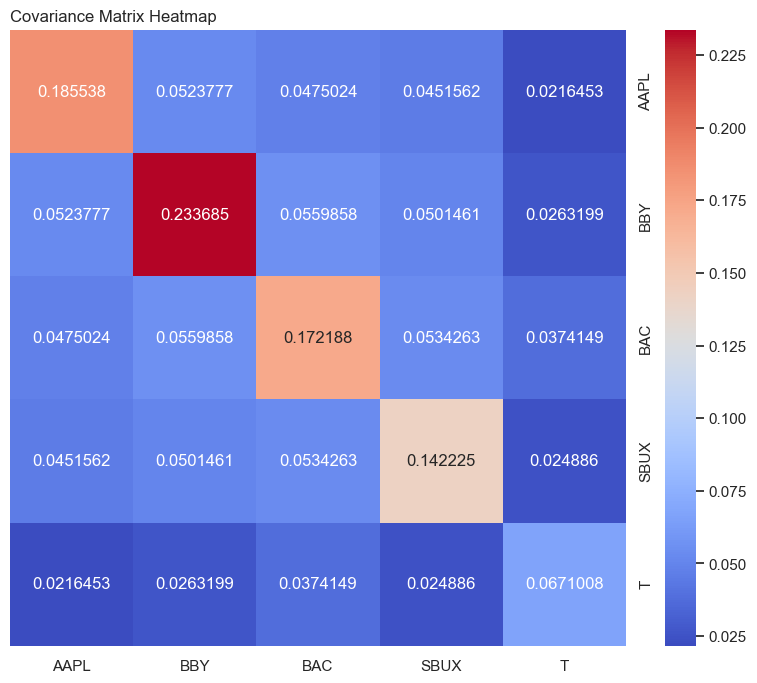

In [50]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt='g', cmap='coolwarm', cbar=True, square=True)
plt.title('Covariance Matrix Heatmap')
plt.show()

Implementing Black Litterman Model

In [98]:
# absolute views implementation
bl = BlackLittermanModel(cov_matrix, absolute_views=abs_viewdict, pi="equal")
# relative views implementation
bl1 = BlackLittermanModel(cov_matrix, Q=Q, P=P, pi="equal")


Initialising the portfolio optimizers
Now that we have the black litterman model instantiated with the views, and priors, we can either use the weights
directly generated by it, or feed those into an efficient frontier (from which we can optimize for max sharpre, min volatility, etc).

In [141]:
rets = bl1.bl_returns() 
# Calculates the adjusted expected returns for each asset in the portfolio using BL Model

# Can either use the weights calculated from the BL model OR use Efficient Frontier with the returns calculated from the BL model

ef = EfficientFrontier(rets, cov_matrix)
# Creates the Efficient Frontier Object which will later be used to optimize the portfolio

weights = bl1.bl_weights()
# Creates the BL object which will later be used to optimize the portfolio

# Optimize for the maximum Sharpe ratio
# This will give you the weights that maximize the Sharpe ratio given the expected returns and covariance matrix
weights_ef = ef.max_sharpe()

# Get the cleaned-up weights. This will remove any tiny values.
cleaned_weights_ef = ef.clean_weights()

# This will output the optimized portfolio using Black-Litterman
print(f"Black Litterman Only {bl.clean_weights()}")

# This will output the optimized portfolio using Efficient Frontier
print(f"Efficient Frontier with Black Litterman {cleaned_weights_ef}")
# plotting.plot_efficient_frontier(ef, show_tickers=True)


Black Litterman Only OrderedDict([('AAPL', 0.29999), ('BBY', 0.11497), ('BAC', 0.02434), ('SBUX', 0.36173), ('T', 0.19897)])
Efficient Frontier with Black Litterman OrderedDict([('AAPL', 0.37716), ('BBY', 0.06922), ('BAC', 0.0), ('SBUX', 0.41903), ('T', 0.13459)])


In [142]:
# How much of each asset to buy for a given portfolio value, in this case $15,000 using BL weights
latest_prices = get_latest_prices(prices)
allocation, leftover = DiscreteAllocation(weights, latest_prices, total_portfolio_value=15000).lp_portfolio()
print("Discrete Allocation:", allocation)
# Calculate and print the value of each allocation
allocation_value = {}
for ticker, shares in allocation.items():
    allocation_value[ticker] = latest_prices[ticker] * shares
    print(f"The value of the allocation for {ticker} is: ${allocation_value[ticker]}")
print("Funds Remaining: $", leftover)

Discrete Allocation: {'BBY': 31, 'SBUX': 71, 'T': 341, 'BAC': -58}
The value of the allocation for BBY is: $2333.3698959350586
The value of the allocation for SBUX is: $6958.0
The value of the allocation for T is: $4995.649869918823
The value of the allocation for BAC is: $-1680.839973449707
Funds Remaining: $ 719.2387883173776


In [143]:
# How much of each asset to buy for a given portfolio value, in this case $15,000 using EF weights
latest_prices = get_latest_prices(prices)
allocation, leftover = DiscreteAllocation(cleaned_weights_ef, latest_prices, total_portfolio_value=15000).lp_portfolio()
print("Discrete Allocation:", allocation)
# Calculate and print the value of each allocation
allocation_value = {}
for ticker, shares in allocation.items():
    allocation_value[ticker] = latest_prices[ticker] * shares
    print(f"The value of the allocation for {ticker} is: ${allocation_value[ticker]}")
print("Funds Remaining: $", leftover)

Discrete Allocation: {'BBY': 24, 'BAC': 49, 'SBUX': 71, 'T': 280}
The value of the allocation for BBY is: $1806.4799194335938
The value of the allocation for BAC is: $1420.01997756958
The value of the allocation for SBUX is: $6958.0
The value of the allocation for T is: $4101.999893188477
Funds Remaining: $ 713.5002084219886


Backtesting - BL ONLY

In [144]:
daily_returns = prices.pct_change().dropna()

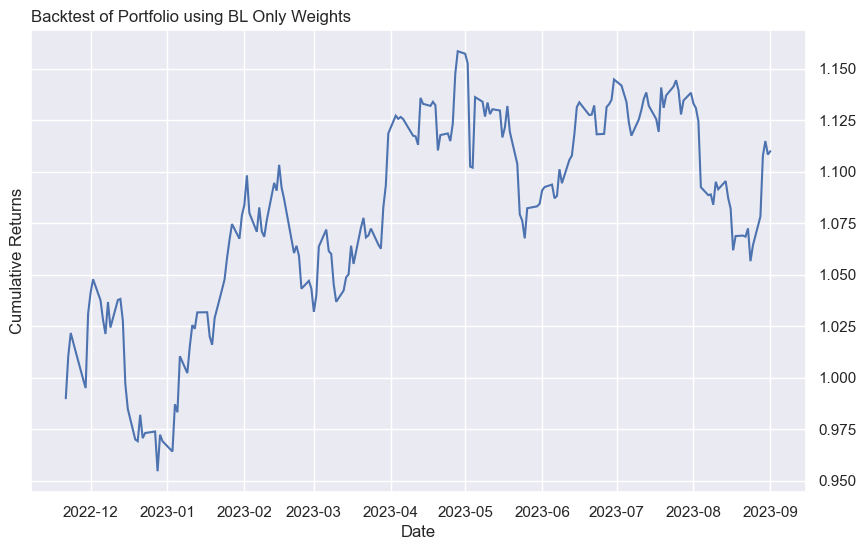

In [145]:
# Multiply daily returns by weights to get portfolio's daily returns
portfolio_daily_returns = (daily_returns * list(weights.values())).sum(axis=1)

# Calculate cumulative returns
portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns.values)
plt.title('Backtest of Portfolio using BL Only Weights')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()


In [151]:
bl1.portfolio_performance(verbose=True)

Expected annual return: 23.2%
Annual volatility: 18.0%
Sharpe Ratio: 1.17


(0.2316068177064843, 0.18013027997154324, 1.1747431788809395)

Backtesting - EF Model

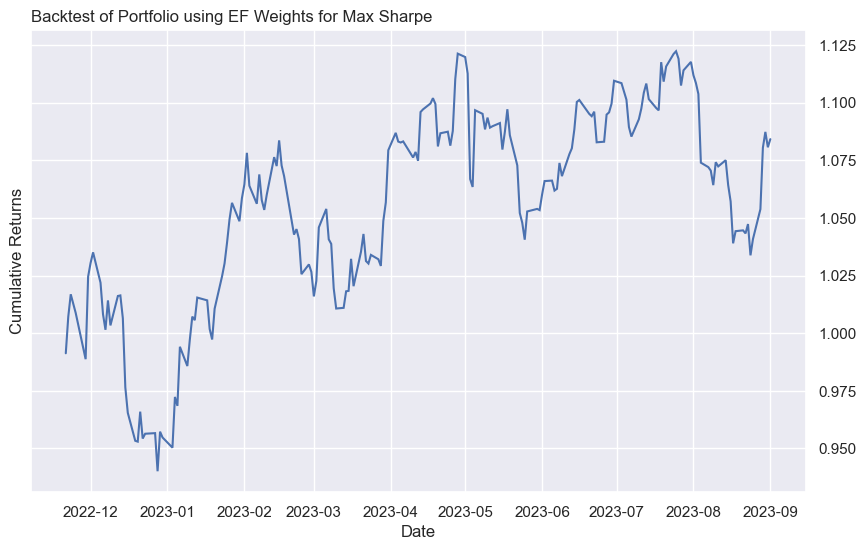

In [148]:
# Multiply daily returns by weights to get portfolio's daily returns
portfolio_daily_returns = (daily_returns * list(cleaned_weights_ef.values())).sum(axis=1)

# Calculate cumulative returns
portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns.values)
plt.title('Backtest of Portfolio using EF Weights for Max Sharpe')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

In [149]:
ef.portfolio_performance(verbose=True)

Expected annual return: 22.2%
Annual volatility: 17.0%
Sharpe Ratio: 1.18


(0.22158161844787302, 0.1703064292083857, 1.183640684528822)